# Using Molecular Dynamics to Assess Protein Stability

This notebook demonstrates how to analyze molecular dynamics (MD) simulations of GFP under
two conditions:

- **Non-stressed:** 300 K, 150 mM NaCl  
- **Stressed:** 340 K, 1000 mM NaCl  

We will:

1. Load per-frame observables pre-extracted from the trajectories
2. Visualize the data to select an **equilibration time** (how much initial trajectory to discard)  
3. Identify autocorrelation time by exploring different **block averaging window sizes**
4. Use the selected **equilibration time** and **block averaging window size** to obtain the means of observables from independent runs
5. Perform statistical comparisons of observables between **Non-stressed** and **Stressed** conditions
6. Construct Free Energy Surface plots of observables for both **Non-stressed** and **Stressed** conditions, with the **delta** between them
7. Discuss the biological meaning of the results and our confidence in them


# Import libraries and define constants

In [17]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Paths (notebook is in md-protein-stability/notebooks/)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")

# Condition keys should match the folder names under data/processed/
CONDITIONS = {
    "300_K_150_mM": "300 K, 150 mM (non-stressed)",
    "340_K_1000_mM": "340 K, 1000 mM (stressed)",
}

# Columns available in the CSVs created by extract_observables.py
METRICS = {
    "rg_tail_nm": "Radius of gyration (tail-excluded, nm)",
    "rmsd_ca_nm": "RMSD (Cα, nm)",
    "helix_frac": "Helix fraction",
    "sheet_frac": "Sheet fraction",
    "other_frac": "Other (coil) fraction",
}

# Candidate window sizes to test (ns).
CANDIDATE_WINDOWS_NS = np.arange(2.0, 21.0, 2.0)


# Load observables from CSV files into accessible memory

In [18]:
def load_condition_runs(processed_dir=DATA_PROCESSED_DIR):
    """
    Load all condition/run CSVs from data/processed/.

    Returns:
      cond_data: dict mapping condition -> {
          "label": human-readable label,
          "runs": list of DataFrames (one per run),
      }
    """
    cond_data = {}
    for cond_slug, label in CONDITIONS.items():
        cond_path = os.path.join(processed_dir, cond_slug)
        if not os.path.isdir(cond_path):
            print(f"[WARN] Condition folder missing: {cond_path}")
            continue

        run_files = sorted(glob.glob(os.path.join(cond_path, "r-*_observables.csv")))
        if not run_files:
            print(f"[WARN] No run CSVs found in {cond_path}")
            continue

        runs = []
        for fpath in run_files:
            df = pd.read_csv(fpath)
            df["run_id"] = os.path.basename(fpath).split("_observables.csv")[0]
            runs.append(df)

        cond_data[cond_slug] = {
            "label": label,
            "runs": runs,
        }

    return cond_data

cond_data = load_condition_runs()
cond_data.keys()


dict_keys(['300_K_150_mM', '340_K_1000_mM'])

# Visualize the Data

We use a sliding window smoother and force y-axis lower limit to 0 to better visualize the large motions of the systems and determine if any are still evolving at simulation end.

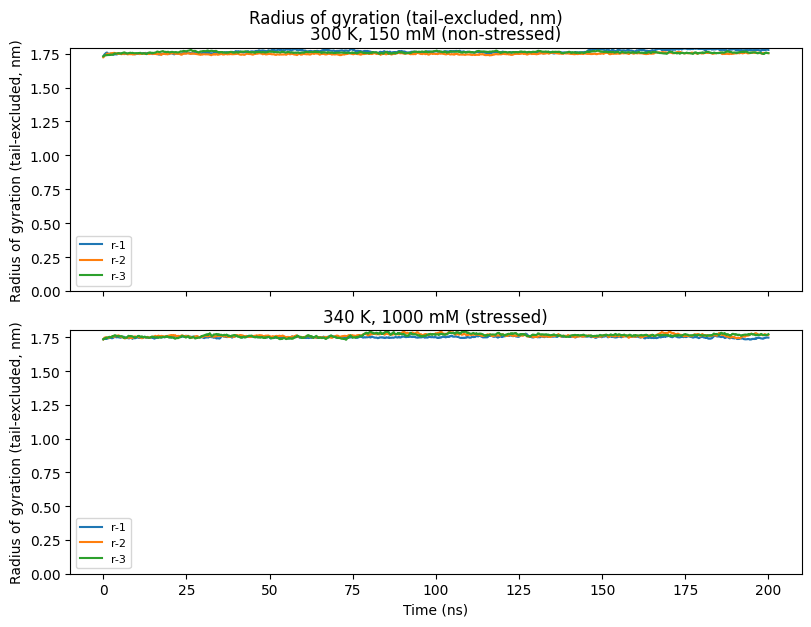

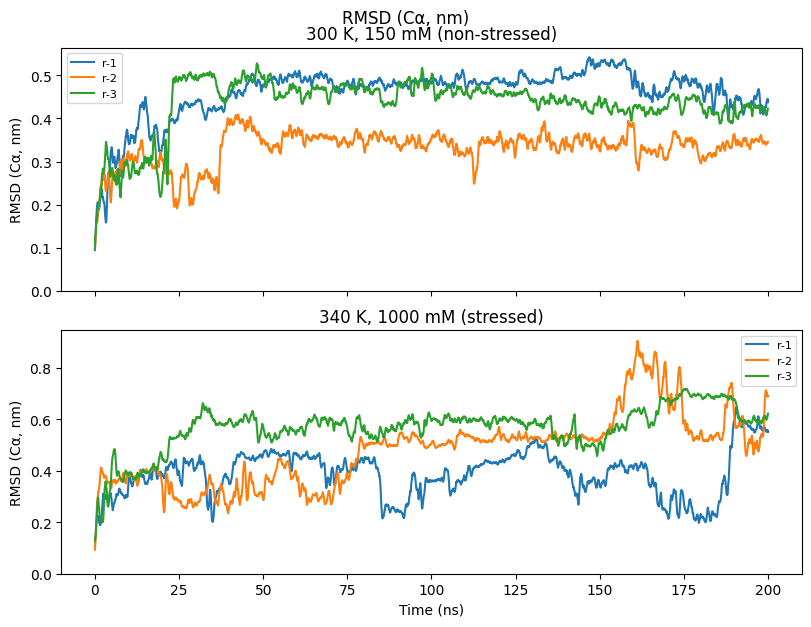

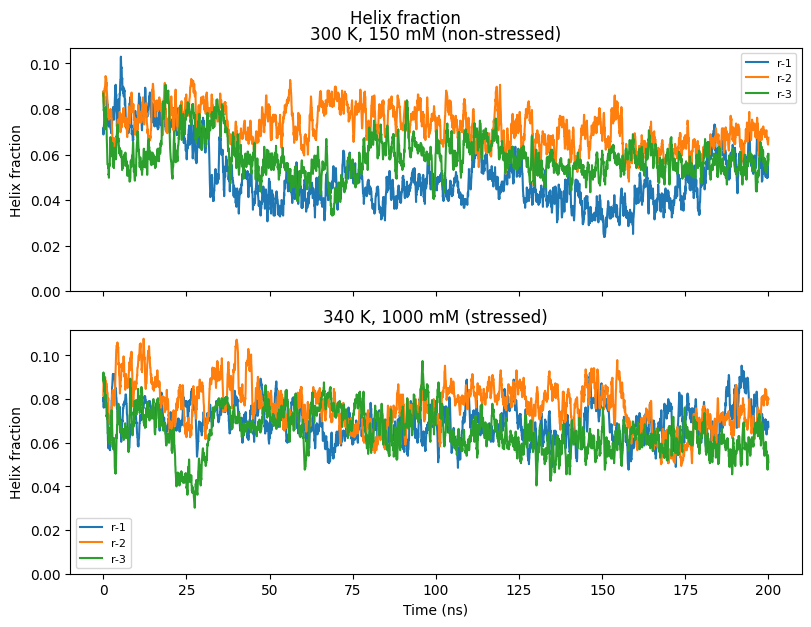

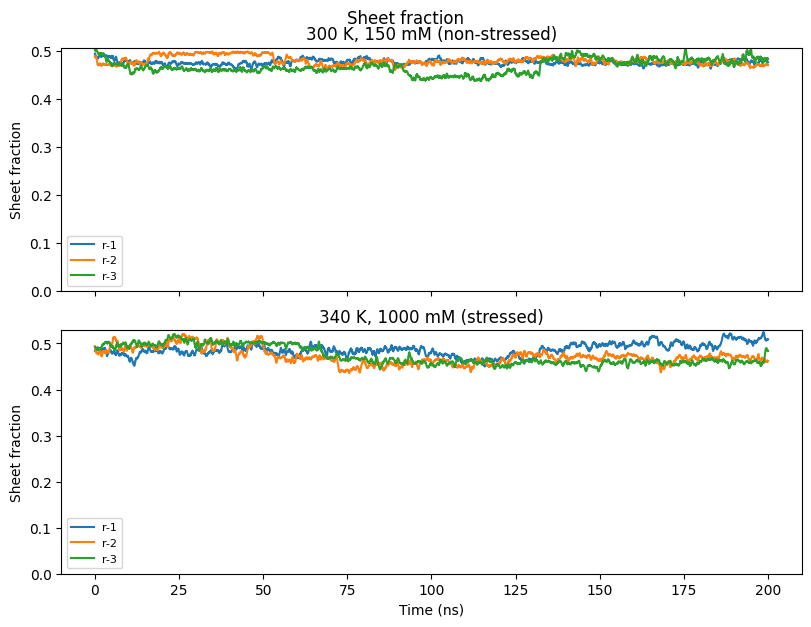

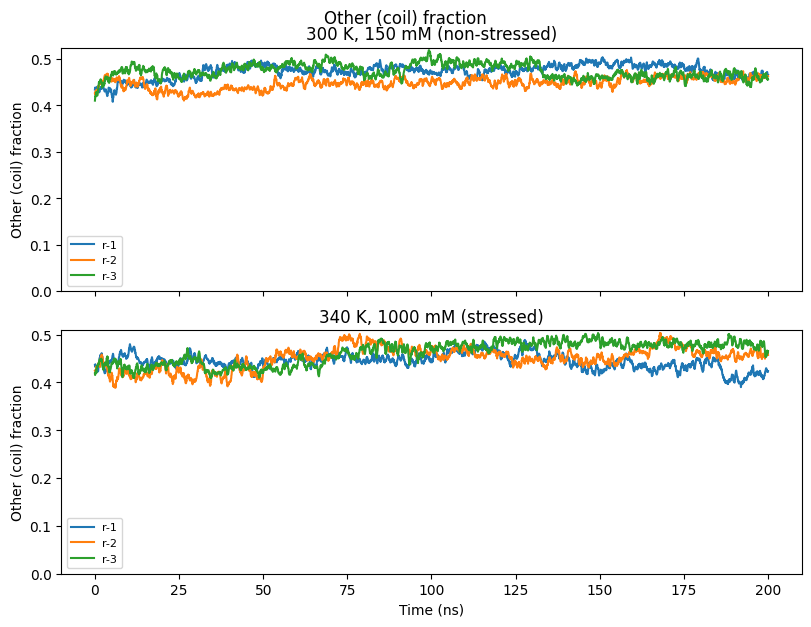

In [19]:
# Helper: sliding-mean smoothing over a fixed window of points
def smooth_series(y, window=50):
    """
    Apply a simple sliding-mean (moving average) smoother.

    Parameters
    ----------
    y : array-like
        1D array of values to smooth.
    window : int
        Number of points in the moving window.

    Returns
    -------
    np.ndarray
        Smoothed values (same length as y).
    """
    s = pd.Series(y)
    return s.rolling(window=window, center=True, min_periods=1).mean().to_numpy()


# Get the conditions in a stable order (assumes 2 conditions)
cond_slugs = list(cond_data.keys())
if len(cond_slugs) != 2:
    print(f"Warning: expected 2 conditions, found {len(cond_slugs)}. "
          "Plots will still be generated for however many conditions exist.")

# Metrics to plot
metric_cols = list(METRICS.keys())

for metric_col in metric_cols:
    pretty_name = METRICS.get(metric_col, metric_col)

    # One figure per measure, stacked by condition
    n_conds = len(cond_slugs)
    fig, axes = plt.subplots(
        nrows=n_conds,
        ncols=1,
        sharex=True,
        figsize=(8, 3 * n_conds),
        constrained_layout=True,
    )

    # If there's only one condition, axes won't be a list
    if n_conds == 1:
        axes = [axes]

    for ax, cond_slug in zip(axes, cond_slugs):
        cond_label = CONDITIONS.get(cond_slug, cond_slug) if "CONDITIONS" in globals() else cond_slug
        runs = cond_data[cond_slug]["runs"]

        for i, df in enumerate(runs):
            if "time_ns" not in df.columns or metric_col not in df.columns:
                continue

            t = df["time_ns"].to_numpy()
            y = df[metric_col].to_numpy()
            y_smooth = smooth_series(y, window=10)

            if "run_id" in df.columns:
                run_name = str(df["run_id"].iloc[0])
            else:
                run_name = f"run_{i+1}"

            ax.plot(t, y_smooth, label=run_name)

        ax.set_ylabel(pretty_name)
        ax.set_title(cond_label)
        ax.legend(fontsize=8, loc="best")
        ax.set_ylim(bottom=0)

    axes[-1].set_xlabel("Time (ns)")
    fig.suptitle(pretty_name, y=1.02, fontsize=12)
    plt.show()


# Select equilibration time

Paying special attention to the secondary structure fractions to determine at what point the systems have stabilized, we determine a **40 ns** trunctation at the beginning of the data will be sufficient. The remaining data can now be analyzed and compared between conditions.

# Define utility functions

We provide equilibration time and window size in nanoseconds (ns). Determing the change (delta) in ns between sequential frames in estimate_dt_ns streamlines definining the blocks used to compute means later for tidier code.

Calculating the mean of each block in block_means instead of the mean of the entire concatenated run allows us to provide a standard error of the mean we are sampling. No reported measurement is useful without also knowing how precise it is.                           


In [20]:
def estimate_dt_ns(df):
    """
    Estimate the time step (ns) from a DataFrame with a 'time_ns' column.
    Uses the median of successive differences.
    """
    t = df["time_ns"].values
    if len(t) < 2:
        return np.nan
    return np.median(np.diff(t))

def block_means(values, dt_ns, window_ns):
    """
    Compute non-overlapping block means for a uniformly-sampled 1D series.

    Args:
      values: 1D numpy array
      dt_ns: timestep in ns
      window_ns: desired block length in ns

    Returns:
      block_means: 1D numpy array of block means
    """
    values = np.asarray(values)
    if values.size < 2:
        return np.array([])

    w_frames = int(round(window_ns / dt_ns))
    if w_frames < 1:
        return np.array([])

    n_blocks = values.size // w_frames
    if n_blocks < 1:
        return np.array([])

    trimmed = values[: n_blocks * w_frames]
    blocks = trimmed.reshape(n_blocks, w_frames)
    return blocks.mean(axis=1)


# Define the function to calculate mean and standard deviation of an observable

In a time series of data points (such as that provided by a molecular dynamics trajectory), each data point is *dependent* on the data points that came before it until sufficient time has passed that the system 'forgets' its previous configuration. To calculate standard error of the mean, we must use *independent* measures of the variable- after autocorrelation has lapsed. We therefore take the mean of the observable in non-overlaping windows, or blocks.


In [21]:
def compute_block_stats_vs_window(
    cond_slug,
    metric_col,
    t_eq_ns=40.0,
    candidate_windows=CANDIDATE_WINDOWS_NS,
):
    """
    For a given condition & metric, compute mean and SEM of block means vs window size
    per run using a given equilibration time.

    For each run:
      - Discard frames with time_ns < t_eq_ns
      - Compute block means for each candidate window_ns
      - Keep any window that yields at least three blocks

    Returns:
      results: dict
        {
          t_eq_ns: {
            run_id: {
              "windows_ns":       1D array of window sizes used,
              "mean_block_means": 1D array of mean(block_means) per window,
              "sem_block_means":  1D array of SEM(block_means) per window,
              "n_blocks":         1D array of number of blocks per window,
            },
            ...
          }
        }
    """
    if cond_slug not in cond_data:
        raise ValueError(f"Unknown condition slug: {cond_slug}")

    condition = cond_data[cond_slug]
    runs = condition["runs"]

    results = {}
    per_run_stats = {}

    for df in runs:
        if metric_col not in df.columns:
            print(f"[WARN] Metric '{metric_col}' not found in run columns.")
            continue

        run_id = df.get("run_id", pd.Series(["unknown"])).iloc[0]

        # Apply equilibration truncation
        df_eq = df[df["time_ns"] >= t_eq_ns].copy()
        if df_eq.empty:
            print(f"[WARN] No frames after {t_eq_ns} ns for run {run_id}")
            continue

        dt_ns = estimate_dt_ns(df_eq)
        if not np.isfinite(dt_ns) or dt_ns <= 0:
            print(f"[WARN] Could not estimate dt_ns for run {run_id}")
            continue

        values = df_eq[metric_col].to_numpy()

        win_list = []
        mean_list = []
        sem_list = []
        nblocks_list = []

        for window_ns in candidate_windows:
            blocks = block_means(values, dt_ns, window_ns)
            n_blocks = blocks.size

            # Only requirement: at least three blocks
            if n_blocks < 3:
                continue

            mean_block_mean = blocks.mean()
            sem = blocks.std(ddof=1) / np.sqrt(n_blocks)

            win_list.append(window_ns)
            mean_list.append(mean_block_mean)
            sem_list.append(sem)
            nblocks_list.append(n_blocks)

        if win_list:
            per_run_stats[run_id] = {
                "windows_ns":       np.array(win_list),
                "mean_block_means": np.array(mean_list),
                "sem_block_means":  np.array(sem_list),
                "n_blocks":         np.array(nblocks_list),
            }

    if per_run_stats:
        results[t_eq_ns] = per_run_stats

    return results


# Visualize the relationship between block size and SEM

If block size is too small, we provide less independent samples of the mean than we think we are because sequential blocks are still correlated. This artificially decreases the standard error of the mean. We can plot the standard error of the mean vs. block size to visualize when autocorrelation is defeated. It will be when the standard error of the mean has stabilized vs. block size.

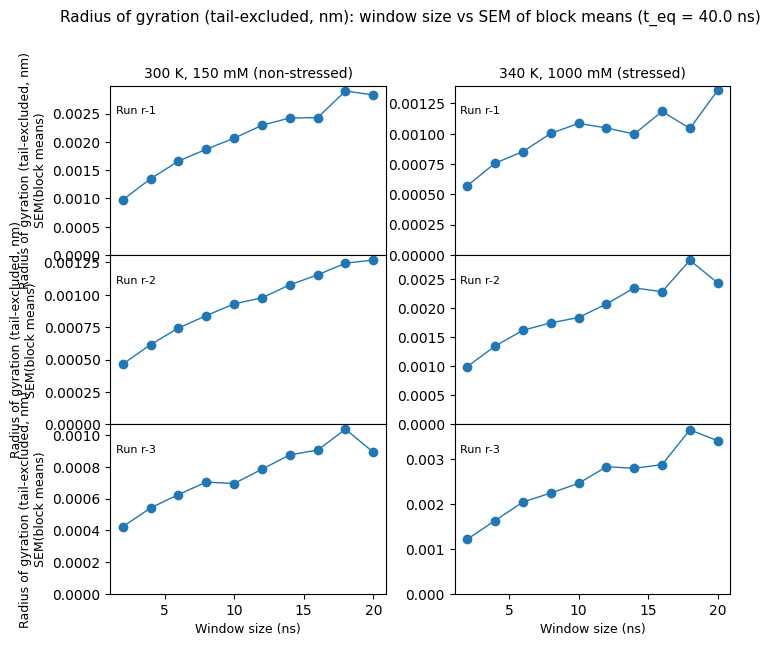

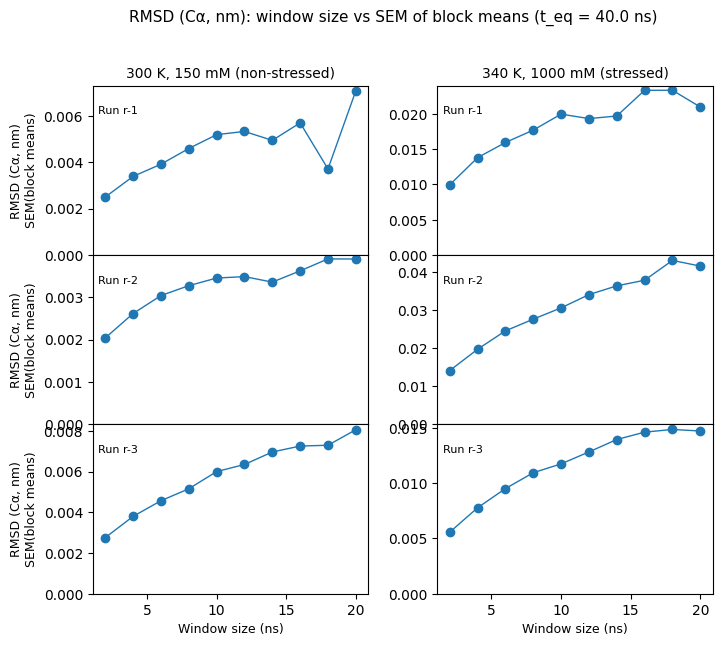

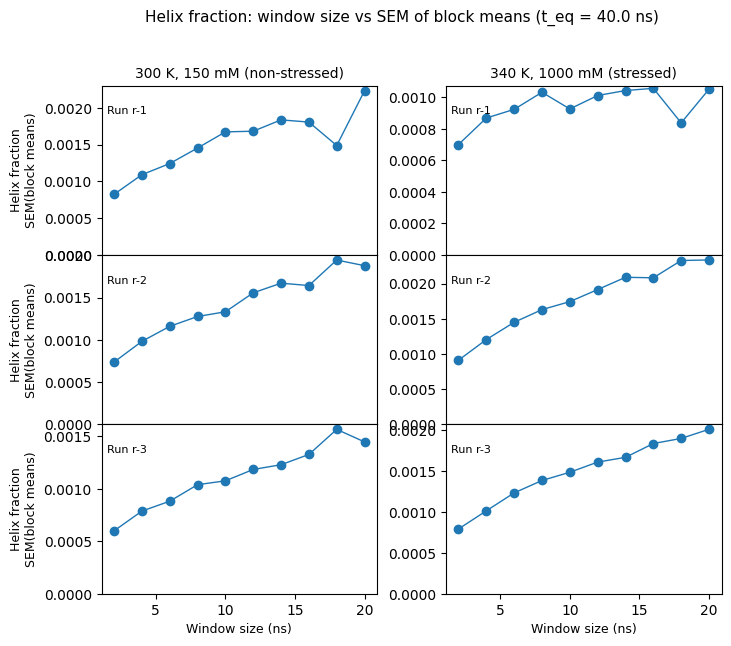

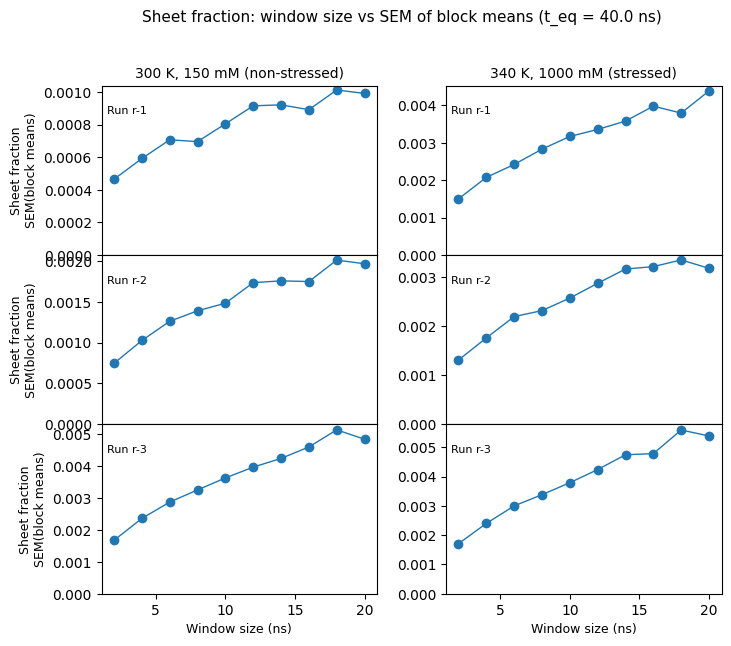

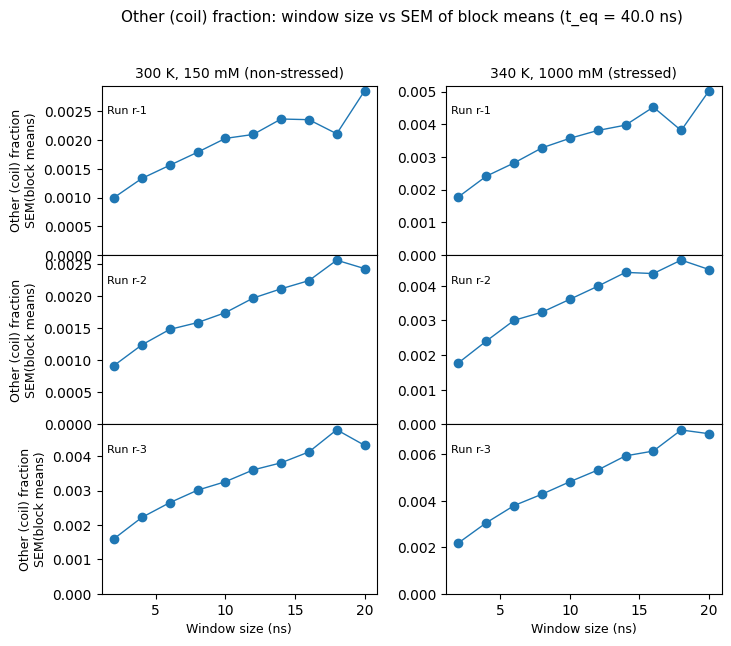

In [22]:
t_eq_ns = 40.0
cond_slugs = list(cond_data.keys())
metric_cols = list(METRICS.keys())

for metric_col in metric_cols:
    pretty_name = METRICS.get(metric_col, metric_col)

    # Collect stats for each condition and run
    cond_run_stats = {}
    max_runs = 0

    for cond_slug in cond_slugs:
        stats = compute_block_stats_vs_window(
            cond_slug=cond_slug,
            metric_col=metric_col,
            t_eq_ns=t_eq_ns,
        )
        per_run = stats.get(t_eq_ns, {})

        # Order runs consistently using cond_data
        ordered_runs = []
        for df in cond_data[cond_slug]["runs"]:
            run_id = df.get("run_id", pd.Series(["unknown"])).iloc[0]
            if run_id in per_run:
                ordered_runs.append((run_id, per_run[run_id]))

        if not ordered_runs:
            continue

        cond_run_stats[cond_slug] = ordered_runs
        max_runs = max(max_runs, len(ordered_runs))

    if not cond_run_stats:
        print(f"[WARN] No block stats for metric '{metric_col}'")
        continue

    # Stable condition order but only for those that have stats
    active_cond_slugs = [c for c in cond_slugs if c in cond_run_stats]
    n_conds = len(active_cond_slugs)

    fig, axes = plt.subplots(
        nrows=max_runs,
        ncols=n_conds,
        figsize=(4 * n_conds, 2.2 * max_runs),
        sharex="col",
        sharey=False,
    )

    # Normalize axes array shape
    if n_conds == 1 and max_runs == 1:
        axes = np.array([[axes]])
    elif n_conds == 1:
        axes = axes.reshape(max_runs, 1)
    elif max_runs == 1:
        axes = axes.reshape(1, n_conds)

    for c_idx, cond_slug in enumerate(active_cond_slugs):
        ordered_runs = cond_run_stats[cond_slug]
        cond_label = (
            CONDITIONS.get(cond_slug, cond_slug)
            if "CONDITIONS" in globals()
            else cond_slug
        )

        for r_idx in range(max_runs):
            ax = axes[r_idx, c_idx]

            if r_idx < len(ordered_runs):
                run_id, run_stats = ordered_runs[r_idx]
                ws = run_stats["windows_ns"]
                sems = run_stats["sem_block_means"]

                # SEM vs window
                ax.plot(ws, sems, marker="o", linewidth=1)

                # Force SEM to start at 0
                ax.set_ylim(bottom=0)

                # Label the condition on the top row
                if r_idx == 0:
                    ax.set_title(cond_label, fontsize=10)

                # Small run label in corner
                ax.text(
                    0.02,
                    0.85,
                    f"Run {run_id}",
                    transform=ax.transAxes,
                    fontsize=8,
                    ha="left",
                    va="center",
                )

            else:
                # No corresponding run: hide unused axis
                ax.axis("off")

            # Hide x tick labels for all but bottom row to make stacks tight
            if r_idx < max_runs - 1:
                ax.tick_params(labelbottom=False)

    # Y label on leftmost column for each row
    for r_idx in range(max_runs):
        axes[r_idx, 0].set_ylabel(f"{pretty_name}\nSEM(block means)", fontsize=9)

    # X label on bottom row
    for c_idx in range(n_conds):
        axes[max_runs - 1, c_idx].set_xlabel("Window size (ns)", fontsize=9)

    fig.suptitle(
        f"{pretty_name}: window size vs SEM of block means (t_eq = {t_eq_ns} ns)",
        y=0.995,
        fontsize=11,
    )

    # Make the three plots per condition tightly stacked (borders touching)
    fig.subplots_adjust(hspace=0.0, wspace=0.25)
    plt.show()


# Select block size

Ideally, there will be at least 20 blocks per run, with block size such that SEM has platued in plots like the above. Here, with limited simulation time, we select block size to provide 10 blocks after equilibration time: **16 ns**.

We then visualize the observables using the selected equilibration time and block size to verify the systems are not still evolving at the end of the simulation.

In [8]:
def compute_block_series_for_run(df, metric_col, t_eq_ns, window_ns):
    """
    Given a single run's DataFrame, compute time-series of block statistics
    for a given metric, equilibration time, and block window.

    Returns
    -------
    block_times_ns : 1D np.ndarray
        Representative time (ns) of each block (mean of times in the block).
    block_means    : 1D np.ndarray
        Mean value of metric within each block.
    block_stds     : 1D np.ndarray
        Standard deviation of metric within each block.
    """
    if "time_ns" not in df.columns or metric_col not in df.columns:
        return None, None, None

    # Apply equilibration truncation
    df_eq = df[df["time_ns"] >= t_eq_ns].copy()
    if df_eq.empty:
        return None, None, None

    # Estimate timestep
    dt_ns = estimate_dt_ns(df_eq)
    if not np.isfinite(dt_ns) or dt_ns <= 0:
        return None, None, None

    values = df_eq[metric_col].to_numpy()
    times = df_eq["time_ns"].to_numpy()

    # Number of frames per block
    frames_per_block = int(round(window_ns / dt_ns))
    if frames_per_block < 1:
        return None, None, None

    # Only use full blocks
    n_full = len(values) // frames_per_block
    if n_full < 1:
        return None, None, None

    values = values[: n_full * frames_per_block]
    times = times[: n_full * frames_per_block]

    val_blocks = values.reshape(n_full, frames_per_block)
    time_blocks = times.reshape(n_full, frames_per_block)

    block_means = val_blocks.mean(axis=1)
    block_stds = val_blocks.std(axis=1, ddof=1)  # per-block std dev
    block_times_ns = time_blocks.mean(axis=1)    # midpoint/mean time of each block

    return block_times_ns, block_means, block_stds


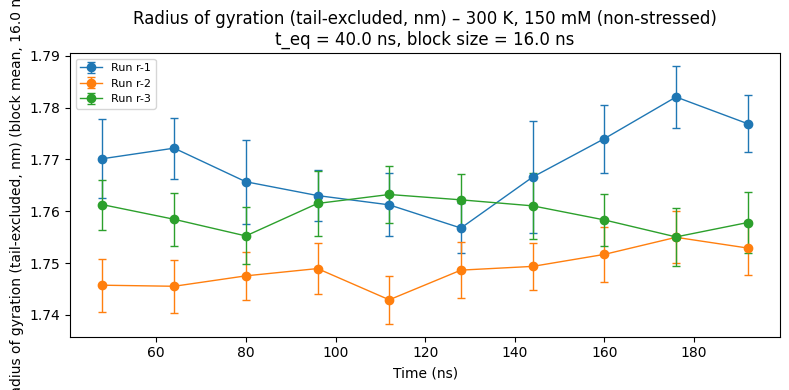

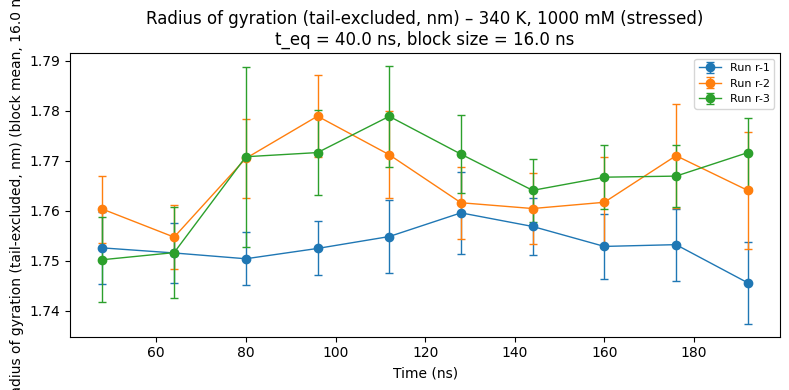

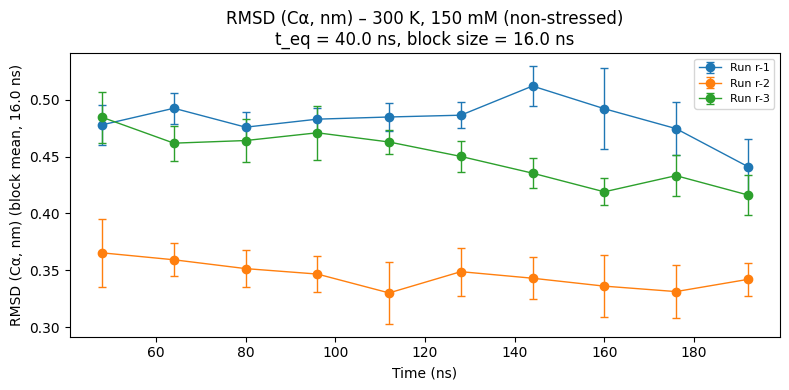

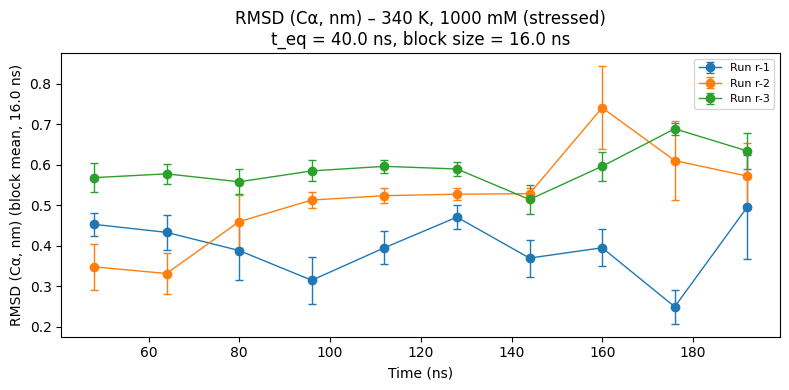

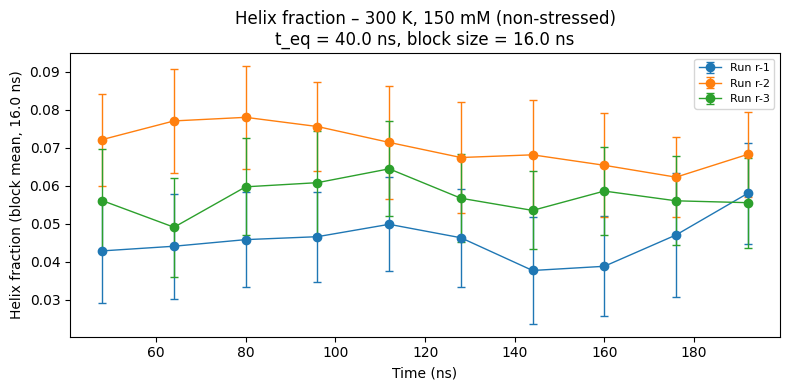

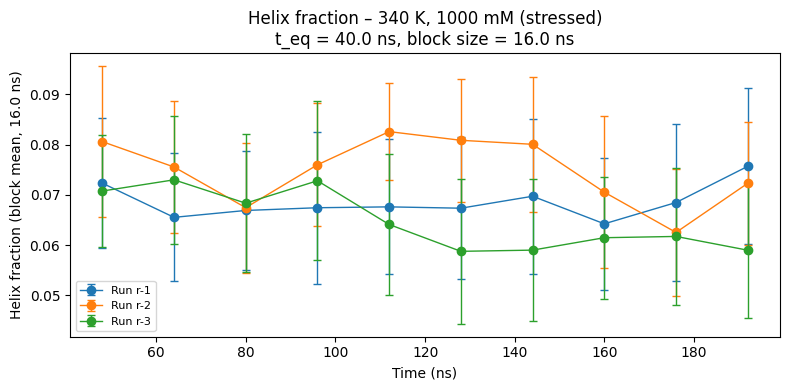

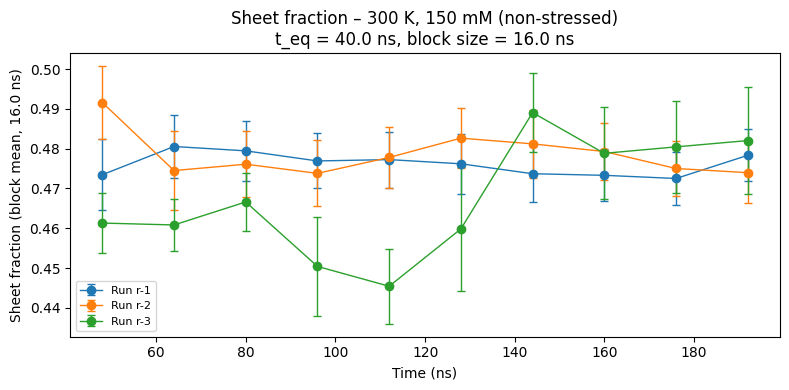

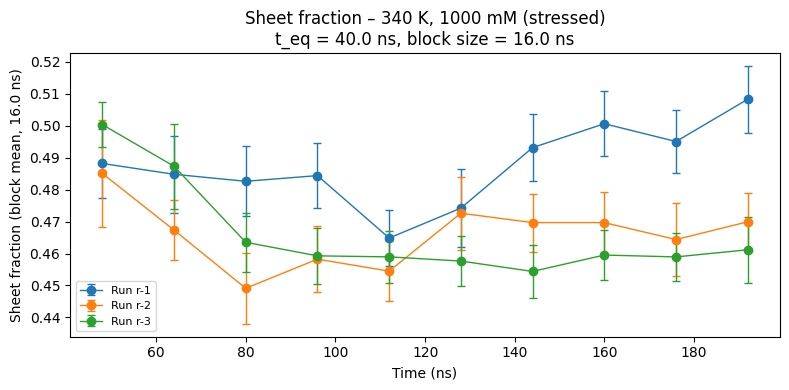

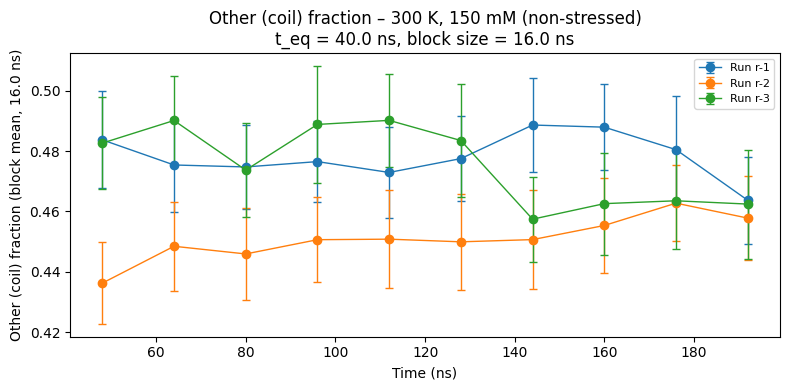

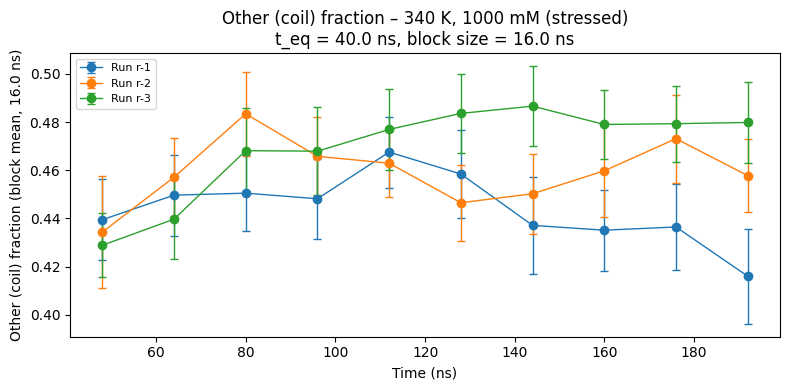

In [23]:
t_eq_ns = 40.0
window_ns = 16.0

cond_slugs = list(cond_data.keys())
metric_cols = list(METRICS.keys())

for metric_col in metric_cols:
    pretty_name = METRICS.get(metric_col, metric_col)

    for cond_slug in cond_slugs:
        cond_label = (
            CONDITIONS.get(cond_slug, cond_slug)
            if "CONDITIONS" in globals()
            else cond_slug
        )

        runs = cond_data[cond_slug]["runs"]

        fig, ax = plt.subplots(figsize=(8, 4))
        have_any = False

        for i, df in enumerate(runs):
            run_id = df.get("run_id", pd.Series([f"{i+1}"])).iloc[0]

            block_times_ns, block_means, block_stds = compute_block_series_for_run(
                df,
                metric_col=metric_col,
                t_eq_ns=t_eq_ns,
                window_ns=window_ns,
            )

            if block_times_ns is None or len(block_times_ns) == 0:
                continue

            have_any = True

            # Plot mean with std-dev as error bars
            ax.errorbar(
                block_times_ns,
                block_means,
                yerr=block_stds,
                marker="o",
                linestyle="-",
                linewidth=1,
                capsize=3,
                label=f"Run {run_id}",
            )

        if not have_any:
            plt.close(fig)
            print(f"[INFO] No block series for {pretty_name}, condition {cond_label}")
            continue

        ax.set_xlabel("Time (ns)")
        ax.set_ylabel(f"{pretty_name} (block mean, {window_ns} ns)")
        ax.set_title(
            f"{pretty_name} – {cond_label}\n"
            f"t_eq = {t_eq_ns} ns, block size = {window_ns} ns"
        )
        ax.legend(fontsize=8, loc="best")

        plt.tight_layout()
        plt.show()


# Statistical Analysis

To determine whether the two simulation conditions differ in their structural behavior, we work with **block-averaged observables**. Using 16 ns blocks after a 40 ns equilibration period reduces the strong autocorrelation present in raw MD frames and produces approximately independent samples suitable for statistical testing.

The visualizations above show that some observables appear stable across time, while others display continuing trends. Ideally, we would perform longer simulations and have more than three replicates per condition. In the absence of additional data, we proceed with the most statistically defensible approach available to us.

For **Rg** and **RMSD**, we concatenate the block means across the three runs within each condition and apply **Welch’s t-test**, which does not assume equal variances between groups (we observe wider variances for the stress condition in the plots above). We use a significance threshold of α = 0.05, meaning we accept a 5% probability of declaring a difference when none exists (Type I error).


In [10]:
from scipy.stats import ttest_ind

def collect_block_means_for_cond(cond_slug, metric_col, t_eq_ns=40.0, window_ns=16.0):
    """
    Returns a list of per-run block means for the given condition and metric.
    Each element in the list is a 1D array: block_means_of_run_i.
    """
    all_run_block_means = []

    for df in cond_data[cond_slug]["runs"]:
        block_times_ns, block_means, block_stds = compute_block_series_for_run(
            df,
            metric_col=metric_col,
            t_eq_ns=t_eq_ns,
            window_ns=window_ns
        )
        if block_means is not None and len(block_means) > 0:
            all_run_block_means.append(block_means)

    return all_run_block_means


def perform_welch_test(cond1_slug, cond2_slug, metric_col, t_eq_ns=40.0, window_ns=16.0):
    """
    Performs a Welch t-test between two conditions for a given metric.
    Uses concatenated block means across all runs of each condition.
    """
    cond1_blocks = collect_block_means_for_cond(cond1_slug, metric_col, t_eq_ns, window_ns)
    cond2_blocks = collect_block_means_for_cond(cond2_slug, metric_col, t_eq_ns, window_ns)

    # Flatten across runs (block means are treated as independent samples)
    cond1_vals = np.concatenate(cond1_blocks)
    cond2_vals = np.concatenate(cond2_blocks)

    # Welch's t-test
    t_stat, p_val = ttest_ind(cond1_vals, cond2_vals, equal_var=False)

    return {
        "cond1": cond1_slug,
        "cond2": cond2_slug,
        "metric": metric_col,
        "mean_cond1": cond1_vals.mean(),
        "mean_cond2": cond2_vals.mean(),
        "n_blocks_cond1": len(cond1_vals),
        "n_blocks_cond2": len(cond2_vals),
        "t_stat": t_stat,
        "p_value": p_val,
    }


# === RUN THE TESTS FOR Rg AND RMSD ===
metrics_to_test = ["rg_tail_nm", "rmsd_ca_nm"]
# Ensure condition ordering is stable and only two exist
cond_slugs = list(cond_data.keys())
if len(cond_slugs) != 2:
    raise ValueError("Expected exactly two conditions for pairwise comparison.")

cond1, cond2 = cond_slugs

results = []
for metric in metrics_to_test:
    res = perform_welch_test(cond1, cond2, metric_col=metric)
    results.append(res)

results


[{'cond1': '300_K_150_mM',
  'cond2': '340_K_1000_mM',
  'metric': 'rg_tail_nm',
  'mean_cond1': np.float64(1.759023033561383),
  'mean_cond2': np.float64(1.7616108153175853),
  'n_blocks_cond1': 30,
  'n_blocks_cond2': 30,
  't_stat': np.float64(-1.0597006682115135),
  'p_value': np.float64(0.29368629413517744)},
 {'cond1': '300_K_150_mM',
  'cond2': '340_K_1000_mM',
  'metric': 'rmsd_ca_nm',
  'mean_cond1': np.float64(0.42584507906458324),
  'mean_cond2': np.float64(0.5011976652583333),
  'n_blocks_cond1': 30,
  'n_blocks_cond2': 30,
  't_stat': np.float64(-3.1431757281421175),
  'p_value': np.float64(0.002978436000782305)}]

# Interpretation of Welch’s t-test Results

**Radius of gyration (Rg)** yielded a p-value of **0.294**, indicating no statistically detectable difference between the two conditions. Within the limits of 200 ns simulations and three replicates, GFP maintains a similar global compactness regardless of thermal or salt stress.

In contrast, **RMSD** produced a p-value of **0.003**, providing evidence for a significant difference between conditions. Because RMSD measures deviation from the starting structure (provided as the first frame of MD after EM, NVT, and NPT per run), this suggests that GFP’s backbone undergoes a larger conformational adjustment under the stress condition. RMSD alone does not indicate whether the structure is *more* or *less* stable, only that it moves further from the initial reference. To learn more, we turn to secondary structure composition.


# Permutation Test for Secondary Structure Compositions

Secondary structure fractions (helix, sheet, other) are **compositional data**: they are non-negative and must sum to 1. This means they lie on a constrained geometric space (the simplex), and ordinary Euclidean distances behave poorly. For example, the Euclidean distance between [0.40, 0.40, 0.20] and [0.45, 0.35, 0.20]  is identical to that between  [0.40, 0.40, 0.20] and [0.35, 0.45, 0.20],  even though the biological interpretation of these changes is different.

To compare conditions rigorously, we therefore work in **CLR space** (centered log-ratio transform), which converts each composition into an unconstrained Euclidean vector whose coordinates represent log-ratios of the original fractions. Distances and means in this space are mathematically well-defined and reflect meaningful changes in composition.

For each condition, we compute the **mean CLR vector** and measure the compositional difference between conditions as the Euclidean distance between these two mean vectors. To assess whether this observed difference could arise by chance, we perform a **permutation test**: we pool all block-level CLR samples, shuffle their condition labels, re-group them into two pseudo-conditions of the original sizes, compute the difference between the pseudo-condition means, and repeat this procedure many times to build a null distribution of differences expected under “no real compositional difference.”

If the observed difference between the actual conditions is routinely produced by this null distribution, then we have no evidence of a real shift in secondary structure composition. But if the observed difference is larger than nearly all shuffled differences, we conclude that the secondary structure content between the conditions is significantly different.

# Define helper functions

In [25]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from matplotlib import pyplot as plt

SS_COLS = ["helix_frac", "sheet_frac", "other_frac"]
T_EQ_NS = 40.0
WINDOW_NS = 16.0
N_PERMUTATIONS = 5000

# Small pseudocount to avoid log(0) in CLR transform
PSEUDOCOUNT = 1e-6

# Helpers for block-level compositions

def compute_ss_block_compositions_for_run(df, ss_cols, t_eq_ns, window_ns):
    """
    For a single run DataFrame, compute block-averaged secondary structure compositions.

    Steps:
      1. Keep only frames with time_ns >= t_eq_ns (equilibration truncation).
      2. Estimate the time step dt_ns.
      3. Use dt_ns and window_ns to figure out how many frames per block.
      4. Chop the trajectory into non-overlapping full blocks.
      5. For each block, compute the mean of each secondary structure fraction column.

    Returns
    -------
    block_times_ns : (n_blocks,) array
        Representative time of each block (mean of times in that block).
    block_comps    : (n_blocks, n_ss) array
        Block-averaged compositions (fractions) per block.
        Rows = blocks, columns = ss_cols (in the order passed in).
    """
    if "time_ns" not in df.columns:
        raise ValueError("DataFrame must contain 'time_ns' column.")

    # Ensure the SS columns are present
    for col in ss_cols:
        if col not in df.columns:
            raise ValueError(f"Secondary structure column '{col}' not found in DataFrame.")

    # 1. Apply equilibration cutoff
    df_eq = df[df["time_ns"] >= t_eq_ns].copy()
    if df_eq.empty:
        return None, None

    # 2. Estimate dt_ns
    dt_ns = estimate_dt_ns(df_eq)
    if not np.isfinite(dt_ns) or dt_ns <= 0:
        return None, None

    # 3. Compute frames per block for the chosen window length
    frames_per_block = int(round(window_ns / dt_ns))
    if frames_per_block < 1:
        return None, None

    times = df_eq["time_ns"].to_numpy()
    values = df_eq[ss_cols].to_numpy()  # shape (n_frames, n_ss)

    # 4. Only use full blocks
    n_frames = len(times)
    n_full_blocks = n_frames // frames_per_block
    if n_full_blocks < 1:
        return None, None

    times = times[: n_full_blocks * frames_per_block]
    values = values[: n_full_blocks * frames_per_block, :]

    # Reshape into blocks: (n_blocks, frames_per_block, n_ss)
    times_blocks = times.reshape(n_full_blocks, frames_per_block)
    values_blocks = values.reshape(n_full_blocks, frames_per_block, len(ss_cols))

    # 5. Mean over frames within each block -> (n_blocks, n_ss)
    block_times_ns = times_blocks.mean(axis=1)
    block_comps = values_blocks.mean(axis=1)

    return block_times_ns, block_comps

def collect_ss_blocks_for_condition(cond_slug, ss_cols, t_eq_ns, window_ns):
    """
    For a given condition, collect all block-level SS compositions across runs.

    Returns
    -------
    all_block_comps : (N_blocks, n_ss) array
        All block-averaged compositions concatenated over runs.
    all_block_times : (N_blocks,) array
        Corresponding block times.
    run_labels      : (N_blocks,) array
        Run identifier for each block (useful for plotting later).
    """
    if cond_slug not in cond_data:
        raise ValueError(f"Unknown condition slug: {cond_slug}")

    runs = cond_data[cond_slug]["runs"]

    comps_list = []
    times_list = []
    run_label_list = []

    for i, df in enumerate(runs):
        run_id = df.get("run_id", pd.Series([f"{i+1}"])).iloc[0]
        block_times_ns, block_comps = compute_ss_block_compositions_for_run(
            df, ss_cols=ss_cols, t_eq_ns=t_eq_ns, window_ns=window_ns
        )
        if block_comps is None or len(block_comps) == 0:
            continue

        comps_list.append(block_comps)
        times_list.append(block_times_ns)
        run_label_list.append(np.array([run_id] * len(block_times_ns), dtype=object))

    if not comps_list:
        return None, None, None

    all_block_comps = np.vstack(comps_list)
    all_block_times = np.concatenate(times_list)
    run_labels = np.concatenate(run_label_list)

    return all_block_comps, all_block_times, run_labels

# CLR transform helpers

def clr_transform(compositions, pseudocount=1e-6):
    """
    Apply centered log-ratio (CLR) transform to compositional data.

    Parameters
    ----------
    compositions : array-like, shape (n_samples, n_components)
        Each row should be a composition (non-negative, sums ~1).
    pseudocount : float
        Small value added to avoid log(0).

    Returns
    -------
    clr : np.ndarray, shape (n_samples, n_components)
        CLR-transformed vectors; rows sum to ~0.
    """
    X = np.asarray(compositions, dtype=float)

    # 1. Add pseudocount to handle any zeros (important for log)
    X = X + pseudocount

    # 2. Normalize rows to sum to 1 again (to keep them valid compositions)
    row_sums = X.sum(axis=1, keepdims=True)
    X = X / row_sums

    # 3. Compute geometric mean per row in log space and subtract
    log_X = np.log(X)
    gm_log = log_X.mean(axis=1, keepdims=True)  # mean of logs = log(geometric mean)
    clr = log_X - gm_log

    return clr

# Run the actual permutation test

def permutation_test_clr_difference(
    X1_clr, X2_clr, n_permutations=5000, random_state=None
):
    """
    Perform a permutation test on the difference in mean CLR vectors
    between two conditions.

    Test statistic:
      T = || mean(X2_clr) - mean(X1_clr) ||_2   (Euclidean norm)

    Null hypothesis:
      The two conditions have the same underlying composition distribution.
      Under H0, the labels (condition 1 vs condition 2) are exchangeable.

    Procedure:
      1. Compute observed T_obs.
      2. Pool all samples and their labels.
      3. Repeatedly shuffle labels, split back into "pseudo-groups" with the
         same sizes as X1_clr and X2_clr, compute T_perm each time.
      4. p-value = (1 + number of T_perm >= T_obs) / (1 + n_permutations).

    Returns
    -------
    p_value : float
        Estimated permutation p-value.
    T_obs   : float
        Observed test statistic.
    T_perm  : np.ndarray
        All permutation test statistics (for visualization if desired).
    """
    rng = np.random.default_rng(random_state)

    n1 = X1_clr.shape[0]
    n2 = X2_clr.shape[0]

    # Observed means and test statistic
    mean1 = X1_clr.mean(axis=0)
    mean2 = X2_clr.mean(axis=0)
    T_obs = norm(mean2 - mean1)

    # Pool the data
    X_all = np.vstack([X1_clr, X2_clr])
    labels = np.array([0] * n1 + [1] * n2)

    T_perm = np.empty(n_permutations, dtype=float)

    for i in range(n_permutations):
        # Shuffle labels
        shuffled = rng.permutation(labels)

        # Split according to shuffled labels, but keep group sizes n1, n2
        # Strategy: pick the first n1 samples with label 0, and first n2 with label 1
        # to preserve group sizes.
        idx0 = np.where(shuffled == 0)[0]
        idx1 = np.where(shuffled == 1)[0]

        # If for some weird reason we don't get enough of one label (extremely unlikely),
        # reshuffle.
        if len(idx0) < n1 or len(idx1) < n2:
            # Try again in this iteration
            i -= 1
            continue

        perm_group1 = X_all[idx0[:n1]]
        perm_group2 = X_all[idx1[:n2]]

        T_perm[i] = norm(perm_group2.mean(axis=0) - perm_group1.mean(axis=0))

    # Compute p-value (add 1 in numerator and denominator for stability)
    p_value = (1.0 + np.sum(T_perm >= T_obs)) / (1.0 + n_permutations)

    return p_value, T_obs, T_perm


# Run permutation test

In [27]:
cond_slugs = list(cond_data.keys())
if len(cond_slugs) != 2:
    raise ValueError("Expected exactly two conditions for secondary-structure comparison.")

cond1_slug, cond2_slug = cond_slugs

cond1_label = CONDITIONS.get(cond1_slug, cond1_slug) if "CONDITIONS" in globals() else cond1_slug
cond2_label = CONDITIONS.get(cond2_slug, cond2_slug) if "CONDITIONS" in globals() else cond2_slug

# 1) Collect block-level compositions for each condition
X1, times1, runs1 = collect_ss_blocks_for_condition(
    cond1_slug, SS_COLS, t_eq_ns=T_EQ_NS, window_ns=WINDOW_NS
)
X2, times2, runs2 = collect_ss_blocks_for_condition(
    cond2_slug, SS_COLS, t_eq_ns=T_EQ_NS, window_ns=WINDOW_NS
)

if X1 is None or X2 is None:
    raise RuntimeError("Could not collect block-level SS compositions for one or both conditions.")

print(f"{cond1_label}: {X1.shape[0]} blocks, {X1.shape[1]} SS components")
print(f"{cond2_label}: {X2.shape[0]} blocks, {X2.shape[1]} SS components")

# 2) CLR-transform the block compositions
X1_clr = clr_transform(X1, pseudocount=PSEUDOCOUNT)
X2_clr = clr_transform(X2, pseudocount=PSEUDOCOUNT)

# 3) Run permutation test
p_value, T_obs, T_perm = permutation_test_clr_difference(
    X1_clr, X2_clr, n_permutations=N_PERMUTATIONS, random_state=42 # Hitchhiker's Guide to the Galaxy's answer to the ultimate question of life, the universe, and everything
)

print("\n=== Permutation test on CLR-transformed SS compositions ===")
print(f"Conditions: {cond1_label} vs {cond2_label}")
print(f"Observed test statistic (||mean2 - mean1||): {T_obs:.4g}")
print(f"Permutation p-value: {p_value:.4g}")
print(f"(Using {N_PERMUTATIONS} permutations)\n")

# 4) Report mean fractions (back in fraction space, not CLR)
mean_frac1 = X1.mean(axis=0)
mean_frac2 = X2.mean(axis=0)

# Compute SEM of fractions per condition for simple bars
sem_frac1 = X1.std(axis=0, ddof=1) / np.sqrt(X1.shape[0])
sem_frac2 = X2.std(axis=0, ddof=1) / np.sqrt(X2.shape[0])

print("Mean secondary structure fractions per condition (± SEM, across blocks):")
for col, m1, s1, m2, s2 in zip(SS_COLS, mean_frac1, sem_frac1, mean_frac2, sem_frac2):
    print(
        f"  {col}: {cond1_label} = {m1:.3f} ± {s1:.3f}, "
        f"{cond2_label} = {m2:.3f} ± {s2:.3f}"
    )

300 K, 150 mM (non-stressed): 30 blocks, 3 SS components
340 K, 1000 mM (stressed): 30 blocks, 3 SS components

=== Permutation test on CLR-transformed SS compositions ===
Conditions: 300 K, 150 mM (non-stressed) vs 340 K, 1000 mM (stressed)
Observed test statistic (||mean2 - mean1||): 0.1741
Permutation p-value: 0.0002
(Using 5000 permutations)

Mean secondary structure fractions per condition (± SEM, across blocks):
  helix_frac: 300 K, 150 mM (non-stressed) = 0.058 ± 0.002, 340 K, 1000 mM (stressed) = 0.069 ± 0.001
  sheet_frac: 300 K, 150 mM (non-stressed) = 0.474 ± 0.002, 340 K, 1000 mM (stressed) = 0.473 ± 0.003
  other_frac: 300 K, 150 mM (non-stressed) = 0.468 ± 0.003, 340 K, 1000 mM (stressed) = 0.457 ± 0.003


# Plot results of permutation test

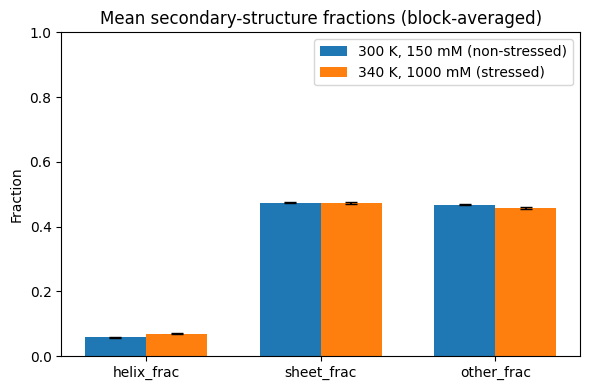

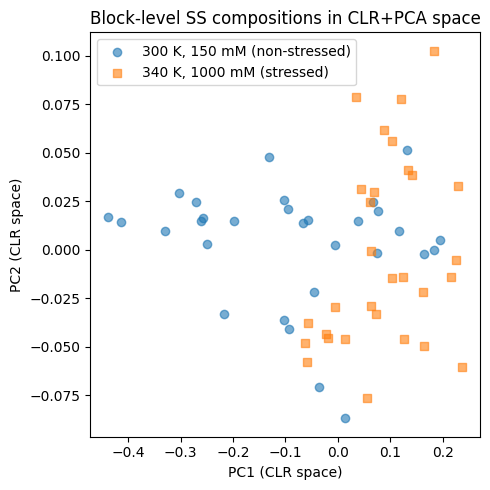

In [29]:
# First plot bars of mean fractions per condition
x = np.arange(len(SS_COLS))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width/2, mean_frac1, width, yerr=sem_frac1, capsize=4, label=cond1_label)
ax.bar(x + width/2, mean_frac2, width, yerr=sem_frac2, capsize=4, label=cond2_label)

ax.set_xticks(x)
ax.set_xticklabels(SS_COLS, rotation=0)
ax.set_ylabel("Fraction")
ax.set_ylim(0, 1)  # SS fractions should be between 0 and 1
ax.set_title("Mean secondary-structure fractions (block-averaged)")
ax.legend()
plt.tight_layout()
plt.show()

# Perform PCA on the CLR-transformed secondary-structure compositions.
# CLR vectors live in a 3D Euclidean space (with one redundant dimension due to the sum-to-zero constraint).
# PCA rotates this space to the directions of greatest variance and allows us to visualize the
# condition separation in the first two principal components.

X_all_clr = np.vstack([X1_clr, X2_clr])
labels_all = np.array([cond1_label] * X1_clr.shape[0] + [cond2_label] * X2_clr.shape[0])

# Center the CLR data
X_centered = X_all_clr - X_all_clr.mean(axis=0)

# Compute PCA manually (2 PCs)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
PCs = U[:, :2] * S[:2]  # scores on first two principal components

pc1 = PCs[:, 0]
pc2 = PCs[:, 1]

fig, ax = plt.subplots(figsize=(5, 5))

for cond_label, marker in [(cond1_label, "o"), (cond2_label, "s")]:
    mask = labels_all == cond_label
    ax.scatter(
        pc1[mask],
        pc2[mask],
        marker=marker,
        alpha=0.6,
        label=cond_label,
    )

ax.set_xlabel("PC1 (CLR space)")
ax.set_ylabel("PC2 (CLR space)")
ax.set_title("Block-level SS compositions in CLR+PCA space")
ax.legend()
plt.tight_layout()
plt.show()

# Interpretation of Permutation Test Results

The permutation test on CLR-transformed secondary-structure compositions indicates a statistically significant difference between the two conditions. The β-sheet content is unchanged, which is consistent with GFP’s expected stability below its melting temperature. However, we observe an increase in α-helix content under the stress condition. This is unexpected given that elevated temperature and high salt typically lead to partial unfolding or coil formation. Because each 16 ns block contributes one independent sample, the total number of blocks per run is lower than desired. Additional replicates and longer trajectories would allow for larger block sizes and increased statistical power. Further simulation would be required before reporting an increase in α-helix content the under stress condition.


# Constructing Free Energy Surfaces

We can also use the block-averaged observables to estimate approximate free energy landscapes for each condition. For a given observable or pair of observables we construct one histogram per block. Each histogram is normalized to obtain the probability distribution of measures observed during the simulation over the bins visited in that block. These block-level probabilities reflect how often the system occupies particular binned values of the observed metric.

Averaging the probability maps over blocks provides an overall estimate of for each condition. We convert these probabilities into a free energy surface using the standard statistical mechanical relation (see code below). Visualizing the free energy as a heatmap provides a qualitative picture of the conformational states sampled under each set of conditions.

Because the present trajectories are relatively short, constructing separate 2D free energy surfaces for each run individually would yield very coarse and noisy landscapes (only ~10 blocks per run after equilibration). To obtain sufficiently smooth and interpretable surfaces, we therefore concatenate the post-equilibration portions of the three runs within each condition and then apply the 16 ns blocking procedure to this combined time series. The resulting block-averaged histograms provide an approximate free energy landscape suitable for **qualitative** comparison between conditions.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

EQUIL_NS  = 40.0    # discard first 40 ns of each run before concatenation
WINDOW_NS = 16.0

X_COL = "rmsd_ca_nm"      # x-axis observable
Y_COL = "rg_tail_nm"      # y-axis observable

N_BINS_RMSD = 50
N_BINS_RG   = 50


# Helper function to provide the full per-metric and per-condition concatenated metric observations

def apply_equil_and_concat_df(cond_slug, x_col, y_col, equil_ns):
    """
    For a given condition in cond_data:
      - For each run, discard frames with time_ns < equil_ns
      - Concatenate x_col and y_col across runs
      - Estimate a representative dt_ns as the median timestep across runs

    Returns
    -------
    dt_ns : float
        Median timestep (ns) across runs after equilibration.
    x_concat : 1D np.ndarray
        Concatenated x_col values (e.g. RMSD).
    y_concat : 1D np.ndarray
        Concatenated y_col values (e.g. Rg).
    """
    if cond_slug not in cond_data:
        raise ValueError(f"Unknown condition slug: {cond_slug}")

    runs = cond_data[cond_slug]["runs"]
    x_parts = []
    y_parts = []
    dt_list = []

    for df in runs:
        # Must have time_ns and the required observable columns
        if "time_ns" not in df.columns:
            continue
        if x_col not in df.columns or y_col not in df.columns:
            continue

        # Apply equilibration mask
        df_eq = df.loc[df["time_ns"] >= equil_ns]
        if df_eq.empty:
            continue

        # Collect data
        x_vals = df_eq[x_col].to_numpy()
        y_vals = df_eq[y_col].to_numpy()
        x_parts.append(x_vals)
        y_parts.append(y_vals)

        # Estimate dt_ns
        dt_run = estimate_dt_ns(df_eq)
        if np.isfinite(dt_run):
            dt_list.append(dt_run)

    # If nothing survived equilibration, return failure
    if not x_parts:
        return None, None, None

    # Concatenate across all runs
    x_concat = np.concatenate(x_parts)
    y_concat = np.concatenate(y_parts)

    # Use median dt across runs if available
    dt_ns = float(np.median(dt_list)) if dt_list else None
    return dt_ns, x_concat, y_concat

def compute_hist_2d(x, y, x_edges, y_edges):
    """
    2D histogram H(x,y) with given edges.
    """
    H, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
    return H


def make_block_histograms(x_concat, y_concat, dt_ns, x_edges, y_edges, window_ns):
    """
    Split concatenated series into non-overlapping blocks of length window_ns,
    and compute 2D histograms for each block.
    """
    hist_blocks = []

    if dt_ns is None or dt_ns <= 0:
        return hist_blocks

    # frames per block
    w_frames = int(round(window_ns / dt_ns))
    if w_frames < 1:
        return hist_blocks

    N = x_concat.shape[0]
    n_blocks = N // w_frames
    if n_blocks < 1:
        return hist_blocks

    for b in range(n_blocks):
        start = b * w_frames
        end   = (b + 1) * w_frames
        x_block = x_concat[start:end]
        y_block = y_concat[start:end]
        H_block = compute_hist_2d(x_block, y_block, x_edges, y_edges)
        hist_blocks.append(H_block)

    return hist_blocks

def block_average_fes(hist_blocks):
    """
    Given a list of per-block histograms H_k(i,j),
    compute block-averaged probability and its variance, then F and sigma_F.

    For each block k:
      P_k(i,j) = H_k(i,j) / sum_i,j H_k(i,j)

    Then we do NOT average F_k directly. Instead:
      P_mean(i,j) = mean_k P_k(i,j)
      Var_P(i,j)  = var_k P_k(i,j)

    Then:
      F_mean(i,j)   = -ln P_mean(i,j)
      sigma_F(i,j) ≈ sqrt(Var_P(i,j)) / P_mean(i,j)

    Returns
    -------
    F_mean : 2D array
        Mean free energy surface (in k_BT units), shifted so min(F_mean) = 0.
    F_err  : 2D array
        Uncertainty in F (approximate, from variance in P_k).
    """
    if not hist_blocks:
        return None, None

    H_array = np.array(hist_blocks, dtype=float)  # (n_blocks, Nx, Ny)
    n_blocks = H_array.shape[0]

    # Compute per-block probabilities
    P_blocks = np.full_like(H_array, np.nan)
    for k in range(n_blocks):
        Hk = H_array[k]
        total = Hk.sum()
        if total <= 0:
            continue
        Pk = Hk / total
        P_blocks[k] = Pk

    with np.errstate(invalid="ignore"):
        P_mean = np.nanmean(P_blocks, axis=0)
        if n_blocks > 1:
            P_var = np.nanvar(P_blocks, axis=0, ddof=1)
        else:
            P_var = np.zeros_like(P_mean)

    # Free energy from mean probability
    F_mean = np.full_like(P_mean, np.nan)
    finite_mask = P_mean > 0
    F_mean[finite_mask] = -np.log(P_mean[finite_mask])

    # Shift F so minimum finite value is zero
    if np.any(finite_mask):
        F_mean[finite_mask] -= np.nanmin(F_mean[finite_mask])

    # Error propagation: sigma_F ≈ sqrt(Var_P) / P_mean
    F_err = np.full_like(P_mean, np.nan)
    valid_err_mask = (P_mean > 0) & np.isfinite(P_var)
    F_err[valid_err_mask] = np.sqrt(P_var[valid_err_mask]) / P_mean[valid_err_mask]

    return F_mean, F_err

300 K, 150 mM (non-stressed): 30 blocks
340 K, 1000 mM (stressed): 30 blocks


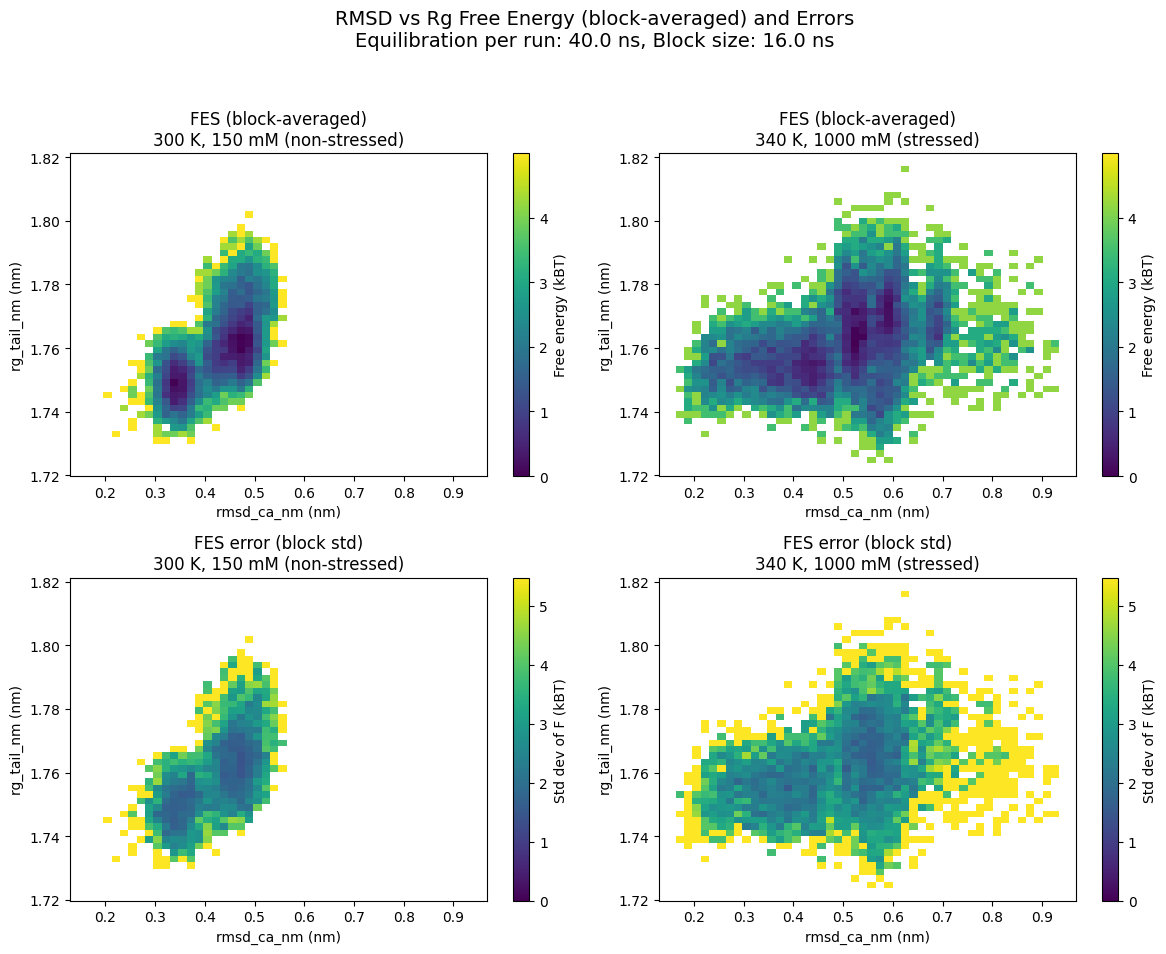

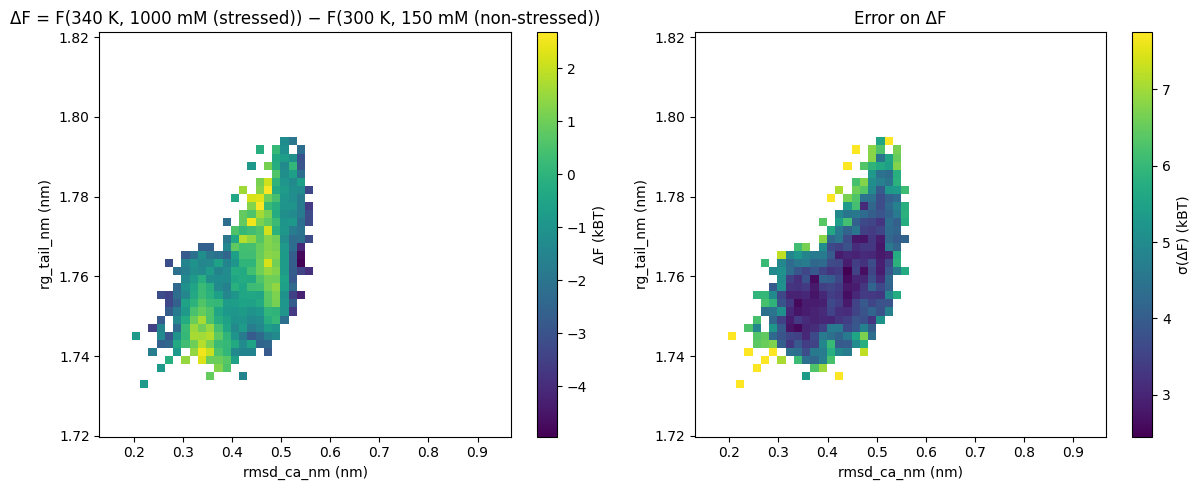

In [36]:
# Get the two conditions from cond_data
cond_slugs = list(cond_data.keys())
if len(cond_slugs) < 2:
    raise ValueError("Need at least two conditions in cond_data for FES comparison.")
cond1_slug, cond2_slug = cond_slugs[:2]

cond1_label = CONDITIONS.get(cond1_slug, cond1_slug) if "CONDITIONS" in globals() else cond1_slug
cond2_label = CONDITIONS.get(cond2_slug, cond2_slug) if "CONDITIONS" in globals() else cond2_slug

# Apply equilibration per run, then concatenate across runs (per condition)
dt1, x1_all, y1_all = apply_equil_and_concat_df(cond1_slug, X_COL, Y_COL, EQUIL_NS)
dt2, x2_all, y2_all = apply_equil_and_concat_df(cond2_slug, X_COL, Y_COL, EQUIL_NS)

if x1_all is None or x2_all is None:
    raise RuntimeError("Insufficient data after equilibration for one or both conditions.")

# Global ranges for axes and binning
x_all = np.concatenate([x1_all, x2_all])  # RMSD
y_all = np.concatenate([y1_all, y2_all])  # Rg

x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = y_all.min(), y_all.max()

# Small padding
x_pad = 0.05 * (x_max - x_min if x_max > x_min else 1.0)
y_pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)

x_min -= x_pad
x_max += x_pad
y_min -= y_pad
y_max += y_pad

x_edges = np.linspace(x_min, x_max, N_BINS_RMSD + 1)
y_edges = np.linspace(y_min, y_max, N_BINS_RG + 1)

extent = [x_min, x_max, y_min, y_max]

# Block histograms per condition
hist_blocks_1 = make_block_histograms(x1_all, y1_all, dt1, x_edges, y_edges, WINDOW_NS)
hist_blocks_2 = make_block_histograms(x2_all, y2_all, dt2, x_edges, y_edges, WINDOW_NS)

if not hist_blocks_1 or not hist_blocks_2:
    raise RuntimeError("Not enough data to form at least one block in each condition.")

print(f"{cond1_label}: {len(hist_blocks_1)} blocks")
print(f"{cond2_label}: {len(hist_blocks_2)} blocks")

# Block-averaged FES and errors (per condition)
F1, F1_err = block_average_fes(hist_blocks_1)
F2, F2_err = block_average_fes(hist_blocks_2)

# Shared color scale for F
finite_F = np.concatenate([
    F1[np.isfinite(F1)],
    F2[np.isfinite(F2)],
]) if np.any(np.isfinite(F1)) and np.any(np.isfinite(F2)) else np.array([])

F_vmax = np.nanmax(finite_F) if finite_F.size > 0 else 1.0

# Shared color scale for F errors
finite_E = np.concatenate([
    F1_err[np.isfinite(F1_err)],
    F2_err[np.isfinite(F2_err)],
]) if np.any(np.isfinite(F1_err)) and np.any(np.isfinite(F2_err)) else np.array([])

E_vmax = np.nanmax(finite_E) if finite_E.size > 0 else 1.0

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: FES non-stressed
ax = axes[0, 0]
im1 = ax.imshow(
    F1.T, origin="lower", extent=extent, aspect="auto",
    vmin=0.0, vmax=F_vmax,
)
ax.set_title(f"FES (block-averaged)\n{cond1_label}")
ax.set_ylabel(f"{Y_COL} (nm)")
ax.set_xlabel(f"{X_COL} (nm)")
cbar1 = fig.colorbar(im1, ax=ax)
cbar1.set_label("Free energy (kBT)")

# Top-right: FES stressed
ax = axes[0, 1]
im2 = ax.imshow(
    F2.T, origin="lower", extent=extent, aspect="auto",
    vmin=0.0, vmax=F_vmax,
)
ax.set_title(f"FES (block-averaged)\n{cond2_label}")
ax.set_ylabel(f"{Y_COL} (nm)")
ax.set_xlabel(f"{X_COL} (nm)")
cbar2 = fig.colorbar(im2, ax=ax)
cbar2.set_label("Free energy (kBT)")

# Bottom-left: FES error non-stressed
ax = axes[1, 0]
im3 = ax.imshow(
    F1_err.T, origin="lower", extent=extent, aspect="auto",
    vmin=0.0, vmax=E_vmax,
)
ax.set_title(f"FES error (block std)\n{cond1_label}")
ax.set_ylabel(f"{Y_COL} (nm)")
ax.set_xlabel(f"{X_COL} (nm)")
cbar3 = fig.colorbar(im3, ax=ax)
cbar3.set_label("Std dev of F (kBT)")

# Bottom-right: FES error stressed
ax = axes[1, 1]
im4 = ax.imshow(
    F2_err.T, origin="lower", extent=extent, aspect="auto",
    vmin=0.0, vmax=E_vmax,
)
ax.set_title(f"FES error (block std)\n{cond2_label}")
ax.set_ylabel(f"{Y_COL} (nm)")
ax.set_xlabel(f"{X_COL} (nm)")
cbar4 = fig.colorbar(im4, ax=ax)
cbar4.set_label("Std dev of F (kBT)")

fig.suptitle(
    "RMSD vs Rg Free Energy (block-averaged) and Errors\n"
    f"Equilibration per run: {EQUIL_NS} ns, Block size: {WINDOW_NS} ns",
    fontsize=14,
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ΔF = F2 - F1
dF = F2 - F1

# Propagated error: sigma(ΔF) = sqrt(sigma_F1^2 + sigma_F2^2)
dF_err = np.sqrt(F1_err**2 + F2_err**2)

# Mask bins where either F is NaN
valid_mask = np.isfinite(F1) & np.isfinite(F2)
dF_plot = np.where(valid_mask, dF, np.nan)
dF_err_plot = np.where(valid_mask, dF_err, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
im = ax.imshow(
    dF_plot.T, origin="lower", extent=extent, aspect="auto",
)
ax.set_title(f"ΔF = F({cond2_label}) − F({cond1_label})")
ax.set_ylabel(f"{Y_COL} (nm)")
ax.set_xlabel(f"{X_COL} (nm)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("ΔF (kBT)")

ax = axes[1]
im = ax.imshow(
    dF_err_plot.T, origin="lower", extent=extent, aspect="auto",
)
ax.set_title("Error on ΔF")
ax.set_ylabel(f"{Y_COL} (nm)")
ax.set_xlabel(f"{X_COL} (nm)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("σ(ΔF) (kBT)")

fig.tight_layout()
plt.show()


# Interpreting Free Energy Surfaces

The standard errors in the FES and ΔFES plots reinforce the conclusion that the available sampling is limited: in many regions, the uncertainties are comparable to the absolute free energy values themselves. Nevertheless, we can still examine qualitative trends in the landscapes to practice interpreting these representations.

In the non-stressed condition, the free energy landscape shows two well-defined minima (the deep blue regions), corresponding to the most probable combinations of Rg and RMSD sampled by GFP. These minima represent relatively stable backbone conformations. Under the stressed condition, these minima become broader and less distinct. Rather than occupying two narrow basins, the protein samples a wider range of RMSD values while maintaining a similar distribution of Rg. This indicates greater structural flexibility or increased backbone excursions, without a net change in global compactness.

The ΔF surface highlights this shift: regions corresponding to the original minima appear at higher free energy (positive ΔF), while regions at larger RMSD values become more favorable (negative ΔF). Along the upper and lower edges of the landscape, ΔF remains close to zero, suggesting no meaningful change in sampling at extreme Rg values. Given the large errors, these differences should be interpreted cautiously.

Qualitatively, these landscapes suggest that elevated temperature and salt broaden the ensemble of backbone conformations visited by GFP over 200 ns, but do not induce a systematic expansion or contraction of the protein (i.e., Rg remains largely unchanged).
